# GeoPandas Shapefiles UDF Example

> These are Census address blocks; download Shapefile(s) from https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/ADDR/

__Artifacts Generated__
<p/>

1. Volume - `<catalog>.<schema>.census_data/address_block_shapefiles`
1. Table - `<catalog>.<schema>.shape_address_block`

---  
__Last Update:__ 22 NOV 2023 [Mosaic 0.3.12]

## Setup
<p/>

1. [GeoPandas](https://pypi.org/project/geopandas/) - used for Shapefile reading and rendering 
1. [Contextily](https://pypi.org/project/contextily/) - used to add basemap to GeoPandas, supports WGS84 (4326) and Spheric Mercator (3857)
1. Import Databricks columnar functions (including H3) for DBR / DBSQL Photon with `from pyspark.databricks.sql.functions import *`

__Note: If you hit `H3_NOT_ENABLED` [[docs](https://docs.databricks.com/error-messages/h3-not-enabled-error-class.html#h3_not_enabled-error-class)]__

> `h3Expression` is disabled or unsupported. Consider enabling Photon or switch to a tier that supports H3 expressions. [[AWS](https://www.databricks.com/product/aws-pricing) | [Azure](https://azure.microsoft.com/en-us/pricing/details/databricks/) | [GCP](https://www.databricks.com/product/gcp-pricing)]

__Note:__ _Recommend run on DBR 14.1+ for better [Volumes](https://docs.databricks.com/en/sql/language-manual/sql-ref-volumes.html) support._

In [0]:
%pip install geopandas contextily --quiet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *

import contextily as cx
import fiona
import geopandas as gpd
import os
import pandas as pd

In [0]:
spark.conf.set("spark.sql.shuffle.partitions", 10_000)                        # <-- default is 200

# https://spark.apache.org/docs/latest/sql-performance-tuning.html#adaptive-query-execution
# spark.conf.set("spark.databricks.optimizer.adaptive.enabled", True)         # <-- default is true [nuclear option]
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False)        # <-- default is true [softer option]

__Configure Database + Username__

> Note: Adjust this to your own specified [Unity Catalog](https://docs.databricks.com/en/data-governance/unity-catalog/manage-privileges/admin-privileges.html#managing-unity-catalog-metastores) Schema.

In [0]:
catalog_name = "mjohns"
db_name = "census"

sql(f"use catalog {catalog_name}")
sql(f"use schema {db_name}")

Out[3]: DataFrame[]

In [0]:
# %sql show tables

__Setup `ETL_DIR` + `ETL_DIR_FUSE`__

> Note: Adjust this to your own specified [Volume](https://docs.databricks.com/en/ingestion/add-data/upload-to-volume.html#upload-files-to-a-unity-catalog-volume) (under a schema). _You must already have setup the Volume path._

In [0]:
ETL_DIR = f'/Volumes/{catalog_name}/{db_name}/census_data/address_block_shapefiles'
os.environ['ETL_DIR'] = ETL_DIR

dbutils.fs.mkdirs(ETL_DIR)
print(f"...ETL_DIR: '{ETL_DIR}' (create)")

...ETL_DIR: '/Volumes/mjohns/census/census_data/address_block_shapefiles' (create)


In [0]:
ls $ETL_DIR/..

address_block_shapefiles/


## Get All GA Addresses (Shapefiles)
<p/>

* Look for pattern https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/ADDRFEAT/tl_rd22_13*.zip (13 is GA number)

In [0]:
state_num = "13"

__Make `address_features` directory.__

In [0]:
dbutils.fs.mkdirs(f"{ETL_DIR}/address_features")

Out[9]: True

### Get List of Shapefile ZIPs

In [0]:
%sh 
echo "$PWD"
wget -O address_features.txt -nc "https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/ADDRFEAT/"

/databricks/driver
File ‘address_features.txt’ already there; not retrieving.


In [0]:
dbutils.fs.cp("file:/databricks/driver/address_features.txt", ETL_DIR)
display(dbutils.fs.ls(ETL_DIR))

path,name,size,modificationTime
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/,address_features/,0,1700668858233
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features.txt,address_features.txt,774132,1700668858000


__Figure out which rows are within the `<table>` tag and extract the filenames.__

> Since this is all in one file being read on one node, get consistent ordered id for `row_num` (not always true).

In [0]:
tbl_start_row = (
  spark.read.text(f"{ETL_DIR}/address_features.txt")
  .withColumn("row_num", F.monotonically_increasing_id())
  .withColumn("tbl_start_row", F.trim("value") == '<table>')
  .filter("tbl_start_row = True")
  .select("row_num")
).collect()[0][0]

tbl_end_row = (
  spark.read.text(f"{ETL_DIR}/address_features.txt")
  .withColumn("row_num", F.monotonically_increasing_id())
  .withColumn("tbl_end_row", F.trim("value") == '</table>')
  .filter("tbl_end_row = True")
  .select("row_num")
).collect()[0][0]

print(f"tbl_start_row: {tbl_start_row}, tbl_end_row: {tbl_end_row}")

tbl_start_row: 237, tbl_end_row: 3463


In [0]:
state_files = [r[1] for r in (
  spark.read.text(f"{ETL_DIR}/address_features.txt")
  .withColumn("row_num", F.monotonically_increasing_id())
    .filter(f"row_num > {tbl_start_row}")
    .filter(f"row_num < {tbl_end_row}")
  .withColumn("href_start", F.substring_index("value", 'href="', -1))
  .withColumn("href", F.substring_index("href_start", '">', 1))
    .filter(col("href").startswith(f"tl_rd22_{state_num}")) 
  .select("row_num","href")
).collect()]

print(f"len state files? {len(state_files):,}")
state_files[:5]

len state files? 159
Out[16]: ['tl_rd22_13001_addrfeat.zip',
 'tl_rd22_13003_addrfeat.zip',
 'tl_rd22_13005_addrfeat.zip',
 'tl_rd22_13007_addrfeat.zip',
 'tl_rd22_13009_addrfeat.zip']

### Download Shapefile ZIPs (159)

> Could do this in parallel, but keeping on just driver for now so as to not overload Census server with requests.

__Note: writing locally to driver, then copying to volume with `dbutils`.__

In [0]:
import pathlib
import requests

vol_path = pathlib.Path(f"{ETL_DIR}/address_features")
local_path = pathlib.Path(f"address_features")
local_path.mkdir(parents=True, exist_ok=True)

for idx,f in enumerate(state_files):
  idx_str = str(idx).rjust(4)
  
  vol_file = vol_path / f
  if not vol_file.exists():
    local_file = local_path / f 
    print(f"{idx_str} --> '{f}'")
    req = requests.get(f'https://www2.census.gov/geo/tiger/TIGER_RD18/LAYER/ADDRFEAT/{f}')
    with open(local_file, 'wb') as f:
      f.write(req.content)
  else:
    print(f"{idx_str} --> '{f}' exists...skipping")

   0 --> 'tl_rd22_13001_addrfeat.zip' exists...skipping
   1 --> 'tl_rd22_13003_addrfeat.zip' exists...skipping
   2 --> 'tl_rd22_13005_addrfeat.zip' exists...skipping
   3 --> 'tl_rd22_13007_addrfeat.zip' exists...skipping
   4 --> 'tl_rd22_13009_addrfeat.zip' exists...skipping
   5 --> 'tl_rd22_13011_addrfeat.zip' exists...skipping
   6 --> 'tl_rd22_13013_addrfeat.zip' exists...skipping
   7 --> 'tl_rd22_13015_addrfeat.zip' exists...skipping
   8 --> 'tl_rd22_13017_addrfeat.zip' exists...skipping
   9 --> 'tl_rd22_13019_addrfeat.zip' exists...skipping
  10 --> 'tl_rd22_13021_addrfeat.zip' exists...skipping
  11 --> 'tl_rd22_13023_addrfeat.zip' exists...skipping
  12 --> 'tl_rd22_13025_addrfeat.zip' exists...skipping
  13 --> 'tl_rd22_13027_addrfeat.zip' exists...skipping
  14 --> 'tl_rd22_13029_addrfeat.zip' exists...skipping
  15 --> 'tl_rd22_13031_addrfeat.zip' exists...skipping
  16 --> 'tl_rd22_13033_addrfeat.zip' exists...skipping
  17 --> 'tl_rd22_13035_addrfeat.zip' exists...s

In [0]:
dbutils.fs.cp("file:/databricks/driver/address_features", f"{ETL_DIR}/address_features", recurse=True)

Out[39]: True

In [0]:
%sh
# avoid list all files
ls -lh $ETL_DIR/address_features | head -5
echo "..."
ls -lh $ETL_DIR/address_features | tail -5

total 366M
-rwxrwxrwx 1 nobody nogroup  1.8M Oct 23 14:53 tl_rd22_13001_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  888K Oct 23 14:53 tl_rd22_13003_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  814K Oct 23 14:53 tl_rd22_13005_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  447K Oct 23 14:53 tl_rd22_13007_addrfeat.zip
...
-rwxrwxrwx 1 nobody nogroup  4.2M Oct 23 14:53 tl_rd22_13313_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  966K Oct 23 14:53 tl_rd22_13315_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  1.1M Oct 23 14:53 tl_rd22_13317_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  1.1M Oct 23 14:53 tl_rd22_13319_addrfeat.zip
-rwxrwxrwx 1 nobody nogroup  1.9M Oct 23 14:53 tl_rd22_13321_addrfeat.zip


### Test Render with GeoPandas

> Just rendering the first file `tl_rd22_13001_addrfeat.zip` for an example. 

In [0]:
# %sh
# - Can copy locally to driver (but don't have to)
# mkdir -p $PWD/address_features
# cp $ETL_DIR/address_features/tl_rd22_13001_addrfeat.zip $PWD/address_features
# ls -lh $PWD/address_features

_Get layer information_

> Fiona is a dependency of GeoPandas.

In [0]:
fiona.listlayers(f"zip://{ETL_DIR}/address_features/tl_rd22_13001_addrfeat.zip") # <- 'zip://' is required here

Out[22]: ['tl_rd22_13001_addrfeat']

In [0]:
#options: driver='shapefile', layer=0; also, 'zip://' is optional
gdf = gpd.read_file(f"{ETL_DIR}/address_features/tl_rd22_13001_addrfeat.zip")
print(f'rows? {gdf.shape[0]:,}, cols? {gdf.shape[1]}')
gdf.head()

rows? 3,762, cols? 26


,TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,...,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geometry
0,4465900,209153283,259208815,None,4006041640541,1105646216480,Holmesville Rd,None,None,10401,...,O,None,None,None,None,None,None,N,N,"LINESTRING (-82.22232 31.64547, -82.22300 31.6..."
1,4466075,209150399,209150092,None,40020469232339,1105646216633,Herbert Rentz Rd,None,None,599,...,O,None,None,None,None,None,None,N,N,"LINESTRING (-82.26755 31.61842, -82.26755 31.6..."
2,645523094,209151387,209151389,None,40020468041410,1105646216724,Milton Hallman,None,None,1094,...,E,None,None,None,None,None,None,N,N,"LINESTRING (-82.26705 31.88152, -82.26705 31.8..."
3,645523094,209151387,209151389,None,40020468040743,1105646216724,Milton Hallman,None,None,1062,...,E,None,None,None,None,None,None,N,N,"LINESTRING (-82.26705 31.88152, -82.26705 31.8..."
4,634061234,264401804,264782725,None,4003995621667,1106087813821,Heath St,None,None,300,...,E,None,None,None,None,None,None,N,N,"LINESTRING (-82.33666 31.73849, -82.33635 31.7..."


_Map Rendering_

> Convert to WGS84 (EPSG=4326) for rendering + this is recommended as baseline for all data layers.

In [0]:
gdf.crs

Out[26]: <Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgi

In [0]:
gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.crs.to_string() # <- will be used with contextily

Out[25]: 'EPSG:4326'

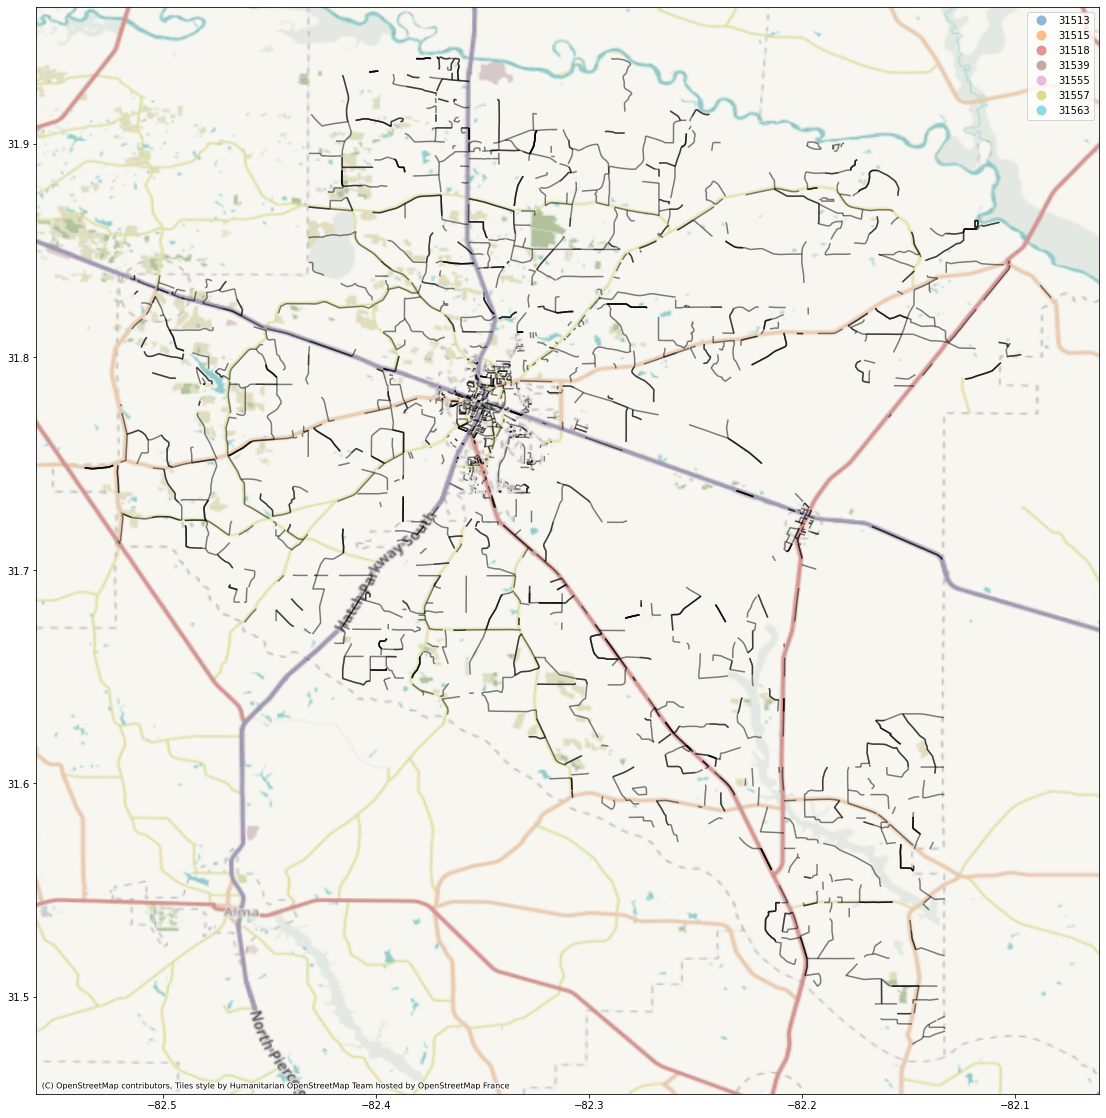

In [0]:
ax = gdf_4326.plot(column='ZIPL', cmap=None, legend=True, figsize=(20, 20), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, zoom='auto', crs=gdf_4326.crs.to_string()) # <- specify crs!

## Shapefiles to Delta Lake

> Will use GeoPandas to read the ShapeFiles and write as Delta Table

__Focus on `ADDRFEAT` (Address Feature) for both geometries and address ranges.__

In [0]:
num_shapefiles = len(dbutils.fs.ls(f"{ETL_DIR}/address_features"))
num_shapefiles

Out[28]: 159

__[1] Define the UDF function.__

> This will be invoked with [applyInPandas](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.GroupedData.applyInPandas.html?highlight=applyinpandas).

In [0]:
gdf_4326.columns

Out[29]: Index(['TLID', 'TFIDL', 'TFIDR', 'ARIDL', 'ARIDR', 'LINEARID', 'FULLNAME',
       'LFROMHN', 'LTOHN', 'RFROMHN', 'RTOHN', 'ZIPL', 'ZIPR', 'EDGE_MTFCC',
       'ROAD_MTFCC', 'PARITYL', 'PARITYR', 'PLUS4L', 'PLUS4R', 'LFROMTYP',
       'LTOTYP', 'RFROMTYP', 'RTOTYP', 'OFFSETL', 'OFFSETR', 'geometry'],
      dtype='object')

In [0]:
def geopandas_read(pdf:pd.DataFrame) -> pd.DataFrame:
  """
  Read using geopandas; recommend using `repartition`
  in caller to drive parallelism.
  - 'path' field assumed to be a Volume path,
    which is automatically FUSE mounted
  - layer_num is either field 'layer_num', if present
    or defaults to 0
  - standardizes to CRS=4326
  """
  pdf_arr = []

  # --- iterate over pdf ---
  for index, row in pdf.iterrows():
    # [1] read 'path' + 'layer_num'
    layer_num = 0
    if 'layer_num' in row:
      layer_num = row['layer_num']

    file_path = row['path'].replace('dbfs:','')

    gdf = gpd.read_file(file_path, layer=layer_num)
    # [2] set CRS to 4326 (WGS84)
    gdf_4326 = gdf.to_crs(epsg=4326)

    # [3] 
    gdf_wkt = gdf_4326.to_wkt

    # [3] convert 'geometry' column to wkt +
    pdf_arr.append(pd.DataFrame(gdf_4326.to_wkt()))

   # return as pandas dataframe
  return pd.concat(pdf_arr)

__[2] We need a schema for our return__ 

> Will use the example from above for this; in production, you will want to be more careful defining the return schema.

In [0]:
spark.createDataFrame(pd.DataFrame(gdf_4326.to_wkt())).schema

Out[31]: StructType([StructField('TLID', LongType(), True), StructField('TFIDL', LongType(), True), StructField('TFIDR', LongType(), True), StructField('ARIDL', StringType(), True), StructField('ARIDR', StringType(), True), StructField('LINEARID', StringType(), True), StructField('FULLNAME', StringType(), True), StructField('LFROMHN', StringType(), True), StructField('LTOHN', StringType(), True), StructField('RFROMHN', StringType(), True), StructField('RTOHN', StringType(), True), StructField('ZIPL', StringType(), True), StructField('ZIPR', StringType(), True), StructField('EDGE_MTFCC', StringType(), True), StructField('ROAD_MTFCC', StringType(), True), StructField('PARITYL', StringType(), True), StructField('PARITYR', StringType(), True), StructField('PLUS4L', NullType(), True), StructField('PLUS4R', NullType(), True), StructField('LFROMTYP', StringType(), True), StructField('LTOTYP', StringType(), True), StructField('RFROMTYP', StringType(), True), StructField('RTOTYP', StringType(),

In [0]:
layer_schema = StructType([
  StructField('TLID', LongType(), True), 
  StructField('TFIDL', LongType(), True), 
  StructField('TFIDR', LongType(), True), 
  StructField('ARIDL', StringType(), True), 
  StructField('ARIDR', StringType(), True), 
  StructField('LINEARID', StringType(), True), 
  StructField('FULLNAME', StringType(), True), 
  StructField('LFROMHN', StringType(), True), 
  StructField('LTOHN', StringType(), True), 
  StructField('RFROMHN', StringType(), True), 
  StructField('RTOHN', StringType(), True), 
  StructField('ZIPL', StringType(), True), 
  StructField('ZIPR', StringType(), True), 
  StructField('EDGE_MTFCC', StringType(), True), 
  StructField('ROAD_MTFCC', StringType(), True), 
  StructField('PARITYL', StringType(), True), 
  StructField('PARITYR', StringType(), True), 
  StructField('PLUS4L', StringType(), True), # <- altered from inferred NullType
  StructField('PLUS4R', StringType(), True), # <- altered from inferred NullType
  StructField('LFROMTYP', StringType(), True), 
  StructField('LTOTYP', StringType(), True), 
  StructField('RFROMTYP', StringType(), True), 
  StructField('RTOTYP', StringType(), True), 
  StructField('OFFSETL', StringType(), True), 
  StructField('OFFSETR', StringType(), True), 
  StructField('geometry', StringType(), True)
])

# layer_schema

__[3] Define Spark DataFrame with Paths__

> We just need a list of files to process, e.g. from "address_features" directory.

In [0]:
df_path = spark.createDataFrame(dbutils.fs.ls(f"{ETL_DIR}/address_features"))
print(f"count? {df_path.count():,}")
df_path.limit(5).display() # <- limiting for ipynb only

count? 159


path,name,size,modificationTime
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13001_addrfeat.zip,tl_rd22_13001_addrfeat.zip,1881047,1698072828000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13003_addrfeat.zip,tl_rd22_13003_addrfeat.zip,908861,1698072803000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13005_addrfeat.zip,tl_rd22_13005_addrfeat.zip,832659,1698072825000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13007_addrfeat.zip,tl_rd22_13007_addrfeat.zip,457413,1698072818000
dbfs:/Volumes/mjohns/census/census_data/address_block_shapefiles/address_features/tl_rd22_13009_addrfeat.zip,tl_rd22_13009_addrfeat.zip,1812853,1698072835000


__[4] Invoke the UDF__

> Group By 'path'; also repartition by 'path' to drive parallelism.

__DRY-RUN:__ _LIMIT 5_

In [0]:
spark.catalog.clearCache()          # <- cache for dev, help avoid recomputes

DRY_LIMIT = 5

out_df = (
  df_path 
    .limit(DRY_LIMIT)               # <- NOTE: DRY-RUN
    .repartition(DRY_LIMIT, "path") # <-repartition                                                                            
    .groupBy("path")                # <- groupby `path`
    .applyInPandas(
      geopandas_read, schema=layer_schema
    )
    .cache()
)

print(f"count? {out_df.count():,}")
out_df.limit(5).display() # <- limiting for ipynb only

count? 11,202


TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geometry
645544426,265026920,265026895,40015491037520,4004032022199,11048687443,Taylor Chapel Rd,1198,1100,1101,1199,31552,31552,S1400,S1400,E,O,null,null,null,null,null,null,N,N,"LINESTRING (-82.632431 31.307748, -82.632431 31.307947, -82.632434 31.309355, -82.632449 31.309766, -82.63247 31.310324, -82.632459 31.311564, -82.632472 31.312339, -82.632523 31.312437, -82.632641 31.312605, -82.632924 31.312855, -82.63334 31.313174, -82.633656 31.313395, -82.634004 31.313588, -82.634468 31.313794, -82.63498 31.313971, -82.635194 31.314052, -82.635409 31.31412, -82.635645 31.314158, -82.635803 31.314115, -82.636063 31.313971, -82.636454 31.313769, -82.636746 31.31361, -82.637252 31.31342, -82.637661 31.313302, -82.637956 31.313284, -82.638186 31.313281, -82.638467 31.313405, -82.639292 31.313676, -82.641407 31.314452, -82.641721 31.314547, -82.642019 31.31467, -82.642283 31.314751, -82.64248 31.314777, -82.642776 31.314801, -82.643103 31.314741, -82.644182 31.314431, -82.644541 31.314314, -82.64521 31.314094, -82.646256 31.313798, -82.646669 31.313725)"
645544467,261841307,265027041,40015491038788,40015491038794,11048688757,Joe Nugent Rd,1098,1000,1199,1101,31642,31642,S1400,S1400,E,O,null,null,null,null,null,null,N,N,"LINESTRING (-82.772789 31.219305, -82.772055 31.219645, -82.7694 31.220937, -82.766646 31.222317, -82.765596 31.222875, -82.765549 31.223159, -82.765498 31.223209, -82.765424 31.224016, -82.765264 31.225835, -82.765254 31.226091, -82.765319 31.226371, -82.76764 31.230318, -82.768255 31.231359, -82.768794 31.232298, -82.769012 31.232963)"
645544467,261841307,265027041,null,40015491038792,11048688757,Joe Nugent Rd,null,null,799,701,null,31642,S1400,S1400,null,O,null,null,null,null,null,null,N,N,"LINESTRING (-82.772789 31.219305, -82.772055 31.219645, -82.7694 31.220937, -82.766646 31.222317, -82.765596 31.222875, -82.765549 31.223159, -82.765498 31.223209, -82.765424 31.224016, -82.765264 31.225835, -82.765254 31.226091, -82.765319 31.226371, -82.76764 31.230318, -82.768255 31.231359, -82.768794 31.232298, -82.769012 31.232963)"
645544531,261848771,265027049,null,40015491046637,11048687316,Betty Smith Rd,null,null,400,498,null,31642,S1400,S1400,null,E,null,null,null,null,null,null,N,N,"LINESTRING (-82.855787 31.216072, -82.854496 31.215622, -82.854367 31.215592, -82.851973 31.214767, -82.850702 31.214334, -82.850551 31.214181, -82.850365 31.213902, -82.850082 31.213652, -82.849817 31.213529, -82.849553 31.213449, -82.849142 31.213426, -82.849011 31.213442, -82.848488 31.213534, -82.848031 31.21364, -82.847803 31.213685, -82.847507 31.213689, -82.847096 31.213611, -82.846404 31.213466, -82.845271 31.213397, -82.84397 31.213404, -82.843746 31.213405, -82.841597 31.213358, -82.840286 31.213419, -82.839517 31.213487, -82.838091 31.213535, -82.836912 31.213616, -82.83629 31.213709, -82.835964 31.213798, -82.835201 31.21419, -82.835001 31.214291, -82.83434 31.214625, -82.833917 31.214814, -82.83382 31.214854, -82.833063 31.215267, -82.832601 31.215505, -82.832197 31.215851, -82.831835 31.216222, -82.831598 31.216383, -82.831358 31.21646, -82.830934 31.216502, -82.830397 31.216559, -82.829889 31.216663, -82.829439 31.216816, -82.828525 31.217182, -82.827602 31.21754, -82.827221 31.217663, -82.825206 31.217668, -82.824561 31.217678, -82.824395 31.217562, -82.823708 31.216759, -82.823043 31.215956, -82.822819 31.215725)"
645544551,261839154,261839154,40020463638867,40020463638283,11048689081,Gardner Ln,101,199,100,198,31642,31642,S1400,S1400,O,E,null,null,null,null,null,null,N,N,"LINESTRING (-82.826027 31.2682, -82.826334 31.266707, -82.826277 31.266557, -82.826171 31.266378, -82.826 31.266174, -82.825821 31.266048, -82.825564 31.265923, -82.825319 31.265817, -82.825082 31.265797)"


In [0]:
out_df.filter(col("plus4l").isNotNull()).count()

Out[36]: 0

__ACTUAL:__ _Write All to Delta Lake_

> We are saving as a managed table named 'shape_address_block'.

In [0]:
sql(f"drop table if exists {catalog_name}.{db_name}.shape_address_block")

(
  df_path 
    .repartition(num_shapefiles, "path") # <-repartition                                                                            
    .groupBy("path")                     # <- groupby `path`
    .applyInPandas(
      geopandas_read, schema=layer_schema
    )
    .write
      .mode("append")
    .saveAsTable(f"{catalog_name}.{db_name}.shape_address_block")
)

In [0]:
df_address = spark.table(f"{catalog_name}.{db_name}.shape_address_block")

print(f"count? {df_address.count():,}")
df_address.limit(1).display()

count? 782,054


TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geometry
629684220,250114008,212667664,null,4004714389943,110453770290,Maria Sorrell Rd,null,null,638,898,null,30450,S1400,S1400,null,E,null,null,null,null,null,null,N,N,"LINESTRING (-81.770631 32.498047, -81.770421 32.498247, -81.770249 32.498447, -81.77015 32.49861, -81.769576 32.499769, -81.769513 32.499879)"


__NOTE: WE DID NOT ADD A SPATIAL INDEX, THAT WILL INVOLVE [1] H3 TESSELLATION and [2] Optimizing, e.g. via [ZORDER](https://docs.databricks.com/en/delta/data-skipping.html) or (newer for DBR 13.3+) [LIQUID CLUSTERING](https://docs.databricks.com/en/delta/clustering.html).__

## Final Sanity Check

In [0]:
%sql show tables

database,tableName,isTemporary
census,ga_address_block,false
census,shape_address_block,false


In [0]:
%sql select * from shape_address_block limit 3

TLID,TFIDL,TFIDR,ARIDL,ARIDR,LINEARID,FULLNAME,LFROMHN,LTOHN,RFROMHN,RTOHN,ZIPL,ZIPR,EDGE_MTFCC,ROAD_MTFCC,PARITYL,PARITYR,PLUS4L,PLUS4R,LFROMTYP,LTOTYP,RFROMTYP,RTOTYP,OFFSETL,OFFSETR,geometry
629684220,250114008,212667664,null,4004714389943,110453770290,Maria Sorrell Rd,null,null,638,898,null,30450,S1400,S1400,null,E,null,null,null,null,null,null,N,N,"LINESTRING (-81.770631 32.498047, -81.770421 32.498247, -81.770249 32.498447, -81.77015 32.49861, -81.769576 32.499769, -81.769513 32.499879)"
629684220,250114008,212667664,null,4005606936146,110453770290,Maria Sorrell Rd,null,null,400,636,null,30461,S1400,S1400,null,E,null,null,null,null,I,null,N,N,"LINESTRING (-81.770631 32.498047, -81.770421 32.498247, -81.770249 32.498447, -81.77015 32.49861, -81.769576 32.499769, -81.769513 32.499879)"
627446457,262876352,262876352,null,4003983702958,1103691641582,Reddick Ln,null,null,201,299,null,30450,S1400,S1400,null,O,null,null,null,null,null,null,N,N,"LINESTRING (-81.972605 32.54902, -81.972476 32.549059, -81.972258 32.549043, -81.972048 32.549045, -81.971557 32.549042, -81.971086 32.549028, -81.970495 32.54898, -81.969882 32.54895, -81.968105 32.548828, -81.967794 32.548799, -81.967726 32.548774, -81.967668 32.548744, -81.967596 32.548678, -81.967541 32.548609, -81.967299 32.548051, -81.967217 32.547851, -81.96715 32.547777, -81.967011 32.547666)"
